# Applying Stereo Depth to a Driving Scenario

## 1 - Getting Set-up 
- The `files_management` package contains pre-developed functions for importing data for the assignment.

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches

%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.2f

import files_management

Now, let's get the pair of stereo images to work with.

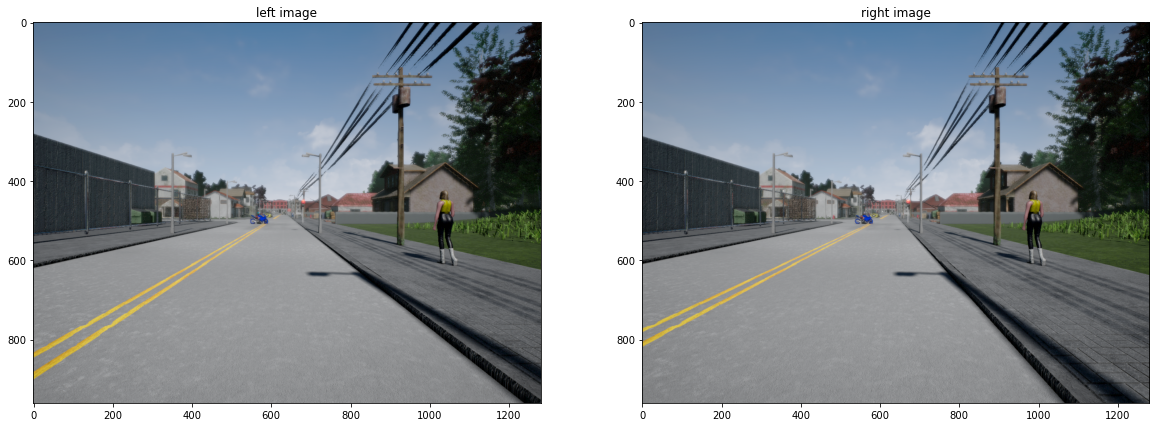

In [3]:
# Read the stereo-pair of images
img_left  = files_management.read_left_image()
img_right = files_management.read_right_image()

# display the two images
_, image_cells = plt.subplots(1, 2, figsize=(20, 20))
image_cells[0].imshow(img_left)
image_cells[0].set_title('left image')
image_cells[1].imshow(img_right)
image_cells[1].set_title('right image')
plt.show()

To go with these images are their respective projection matrices.

In [4]:
# Read the calibration
p_left, p_right = files_management.get_projection_matrices()

# for regular numpy notation instead of scientific one 
np.set_printoptions(suppress=True)

print("p_left \n", p_left)
print("\np_right \n", p_right)

p_left 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   552. ]
 [   0.     0.     1.     1.4]]

p_right 
 [[ 640.     0.   640.  2176. ]
 [   0.   480.   480.   792. ]
 [   0.     0.     1.     1.4]]


## 2 - Estimating Depth

Estimate the depth of a stereo scene using the following sequence of actions:
1. Determine the disparity between the two images.
2. Decompose the projection matrices into the camera intrinsic matrix $K$, and extrinsics $R$, $t$.
3. Estimate depth

### 2.1 - Computing the Disparity

The following `compute_left_disparity_map` function is expected to recieve a stereo pair of images and return a disparity map from the perspective of the left camera. 

There are two OpenCV functions that we can use to compute a disparity map [StereoBM](https://docs.opencv.org/3.4.3/d9/dba/classcv_1_1StereoBM.html) and [StereoSGBM](https://docs.opencv.org/3.4.3/d2/d85/classcv_1_1StereoSGBM.html). 

**Note**: if the disparity output is set to 16-bit fixed-point, we need to divide the output by 16 to obtain the true disparity values. This is because the output has a precision of 1/16, so the bits are shifted left by 4 (corresponding to multiplication by 16). If the disparity output is set to 32-bit floating point, no division by 16 is needed. Check out OpenCV's [compute](https://docs.opencv.org/3.4.3/d2/d6e/classcv_1_1StereoMatcher.html#a03f7087df1b2c618462eb98898841345) function for more details.

Once matcher is chosen, we can call `matcher.compute(img_left, img_right)` to generate the disparity output.

**Note**: Use grayscale images for the `matcher.compute()` method.

For more information on `cvtColor()` refer to the [OpenCV documentation](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab)


In [6]:
def compute_left_disparity_map(img_left, img_right):
    
    window_size = 6
    
    gray_left  = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    matcher = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=96,
        blockSize=11,
        P1=8*3*window_size ** 2,
        P2=32*3*window_size ** 2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    disp_left = matcher.compute(gray_left, gray_right).astype(np.float32)/16
    
    return disp_left

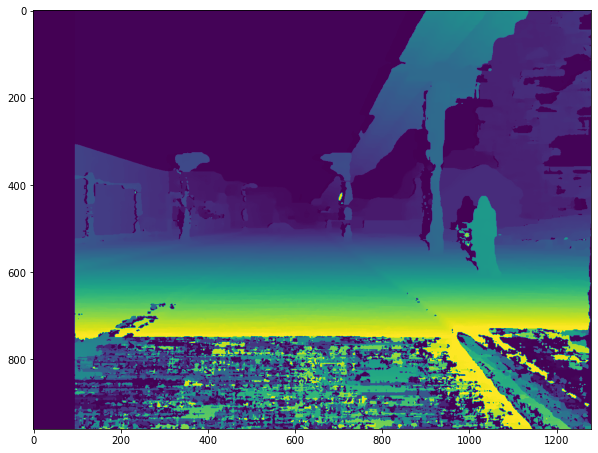

In [7]:
# Compute the disparity map using the fuction above
disp_left = compute_left_disparity_map(img_left, img_right)

# Show the left disparity map
plt.figure(figsize=(10, 10))
plt.imshow(disp_left)
plt.show()

### 2.2 - Decompose the projection matrices

1. Represent $P$ as a combination of the intrinsic parameters $K$ and the extrinsic rotation $R$ and translation $t$ as follows: 
$$ $$
$$P = K[R|t]$$
$$ $$
2. Take the inverse of $KR$, which allows us to perform QR-decomposition to get $R^{-1}$ and $K^{-1}$: 
$$ $$
$$(KR)^{-1} = R^{-1}K^{-1}$$
$$ $$
3. From here it would seem as though we could easily determine $K$, $R$, and $t$.

Unfortunately, this isn't as simple as it seems due to the QR-decomposition isn't unique. This results in us having to check the signs of the diagonal of the $K$ matrix and adjust $R$ appropriately. We must also make assertions about the directions of our camera and image x, y, and z axes.

Fortunately, OpenCV provides us with a single function that does all of this. Using cv2.[decomposeProjectionMatrix()](https://docs.opencv.org/3.4.3/d9/d0c/group__calib3d.html#gaaae5a7899faa1ffdf268cd9088940248).

**Note**: After carrying out the matrix multiplication, the homogeneous component $w_c$ will, in general, not be equal to 1. Therefore, to map back into the real plane we must perform the homogeneous divide or perspective divide by dividing each component by $w_c$

In [8]:
def decompose_projection_matrix(p):
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = t/t[3]
    
    return k, r, t

In [9]:
# Decompose each matrix
k_left, r_left, t_left    = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)

# Display the matrices
print("k_left \n",    k_left)
print("\nr_left \n",  r_left)
print("\nt_left \n",  t_left)
print("\nk_right \n", k_right)
print("\nr_right \n", r_right)
print("\nt_right \n", t_right)

k_left 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_left 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left 
 [[-2.  ]
 [ 0.25]
 [-1.4 ]
 [ 1.  ]]

k_right 
 [[640.   0. 640.]
 [  0. 480. 480.]
 [  0.   0.   1.]]

r_right 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right 
 [[-2.  ]
 [-0.25]
 [-1.4 ]
 [ 1.  ]]


### 2.3 - Generate the depth map

The sequence of this procedure: 

1. Get the focal length $f$ from the $K$ matrix
2. Compute the baseline $b$ using corresponding values from the translation vectors $t$
3. Compute depth map of the image: $$Z = \frac{f b}{x_L - x_R} = \frac{f b}{d}$$ 
In the above equation, $d$ is a disparity map

**Note:** Address problematic disparities (the ones having of 0 and -1) to eliminate potential computational issues.

In [10]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    
    f = k_left[0,0]
    b = t_left[1] - t_right[1]
    
    disp_left[disp_left ==  0] = 0.1
    disp_left[disp_left == -1] = 0.1
    
    depth_map = np.ones(disp_left.shape, dtype=np.single)
    depth_map[:] = (f*b)/disp_left[:]
    
    return depth_map

The depth map is displayed for reference.

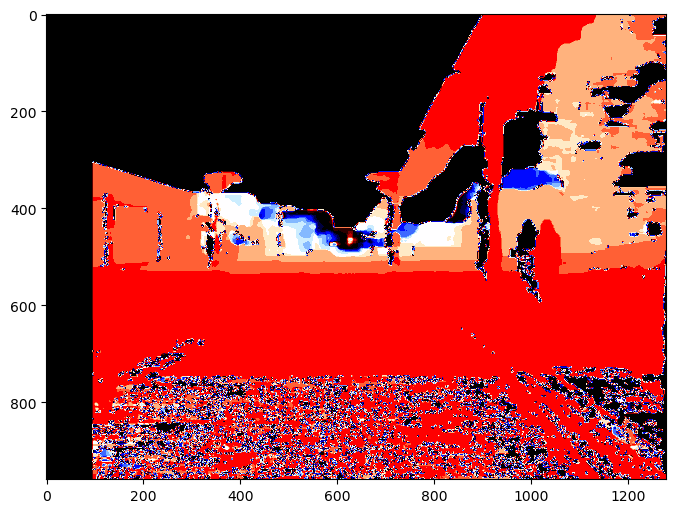

In [11]:
# Get the depth map by calling the above function
depth_map_left = calc_depth_map(disp_left, k_left, t_left, t_right)

# Display the depth map
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(depth_map_left, cmap='flag')
plt.show()

## 3 - Finding the distance to collision

While we may have a map of the depths of each pixel in the scene, our system does not yet know which of these pixels are safe (like the road) or a potential obstacle (like a motorcycle). To find these objects of interest object detector is run that has been trained to select a rectangular section containing the object we are concerned about. 
For now we will just work with the motorcycle image that was identified by the detector.

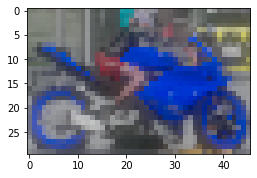

In [12]:
# Get the image of the obstacle
obstacle_image = files_management.get_obstacle_image()

# Show the obstacle image
plt.figure(figsize=(4, 4))
plt.imshow(obstacle_image)
plt.show()

What we would like to do now is have the system automatically determine where this obstacle is in the scene. For this we will use cross correlation, but the algorithm behind cross correlation requires us to perform large numerical computations at each pixel in the image. 
However, we can use cv2.[matchTemplate()](https://docs.opencv.org/3.4.3/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be) function so as to quickly and easily complete the cross-correlation of the obstacle template. From this heatmap we can use the cv2.[minMaxLoc()](https://docs.opencv.org/3.4.3/d2/de8/group__core__array.html#ga8873b86a29c5af51cafdcee82f8150a7) function to extract the position of the obstacle.

In [13]:
def locate_obstacle_in_image(image, obstacle_image):
   
    cross_corr_map = cv2.matchTemplate(image, obstacle_image, method=cv2.TM_CCOEFF)
    _, _, _, obstacle_location = cv2.minMaxLoc(cross_corr_map)

    return cross_corr_map, obstacle_location

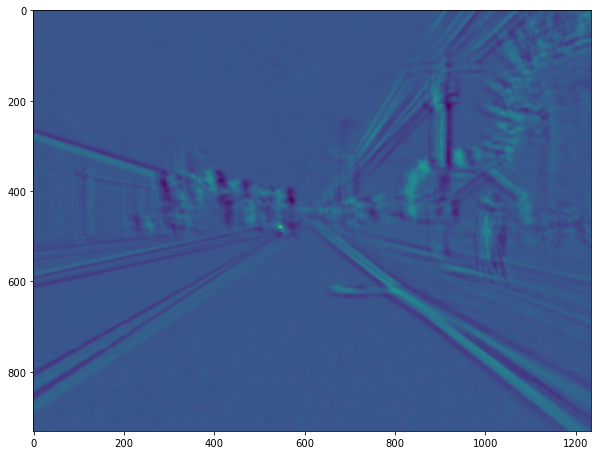

obstacle_location 
 (547, 479)


In [14]:
# Gather the cross correlation map and the obstacle location in the image
cross_corr_map, obstacle_location = locate_obstacle_in_image(img_left, obstacle_image)

# Display the cross correlation heatmap 
plt.figure(figsize=(10, 10))
plt.imshow(cross_corr_map)
plt.show()

# Print the obstacle location
print("obstacle_location \n", obstacle_location)

All that's left to do is to crop the section of the depth map that corresponds to the obstacle and find the nearest point in that crop within that bounding box.

In [15]:
def calculate_nearest_point(depth_map, obstacle_location, obstacle_img):
   
    obstacle_width      = obstacle_img.shape[0]
    obstacle_height     = obstacle_img.shape[1]
    
    obstacle_min_x_pos  = obstacle_location[1]
    obstacle_max_x_pos  = obstacle_location[1] + obstacle_width
    obstacle_min_y_pos  = obstacle_location[0]
    obstacle_max_y_pos  = obstacle_location[0] + obstacle_height
    
    obstacle_depth      = depth_map[obstacle_min_x_pos:obstacle_max_x_pos, obstacle_min_y_pos:obstacle_max_y_pos]
    closest_point_depth = obstacle_depth.min()
    
    # Create the obstacle bounding box 
    obstacle_bbox = patches.Rectangle((obstacle_min_x_pos, obstacle_min_y_pos), obstacle_width, obstacle_height,
                                 linewidth=1, edgecolor='r', facecolor='none')
    
    return closest_point_depth, obstacle_bbox

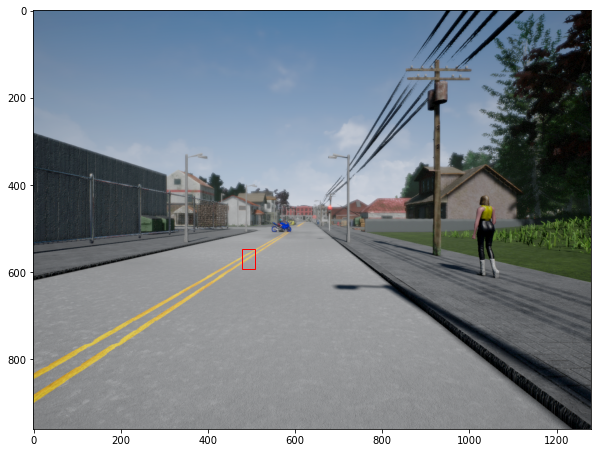

closest_point_depth 28.927


In [16]:
# Use the developed nearest point function to get the closest point depth and obstacle bounding box
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)

# Display the image with the bounding box displayed
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(img_left)
ax.add_patch(obstacle_bbox)
plt.show()

# Print the depth of the nearest point
print("closest_point_depth {0:0.3f}".format(closest_point_depth))

## 4 - Results:

1. The decomposed components of left and right projection matrices from part 2.
2. The estimated obstacle location from part 2.
3. The estimated closest point depth from part 2. 

**Expected Result Output**:

```
Left Projection Matrix Decomposition:
 [[left camera calibration matrix], [left camera rotation matrix], [left camera translation vector]]

Right Projection Matrix Decomposition:
  [[right camera calibration matrix], [right camera rotation matrix], [right camera translation vector]]

Obstacle Location (left-top corner coordinates):
 [x, y]

Closest point depth (meters):
 d
```

In [17]:
# Part 1. Read Input Data
img_left        = files_management.read_left_image()
img_right       = files_management.read_right_image()
p_left, p_right = files_management.get_projection_matrices()


# Part 2. Estimating Depth
disp_left                 = compute_left_disparity_map(img_left, img_right)
k_left, r_left, t_left    = decompose_projection_matrix(p_left)
k_right, r_right, t_right = decompose_projection_matrix(p_right)
depth_map_left            = calc_depth_map(disp_left, k_left, t_left, t_right)


# Part 3. Finding the distance to collision
obstacle_image                     = files_management.get_obstacle_image()
cross_corr_map, obstacle_location  = locate_obstacle_in_image(img_left, obstacle_image)
closest_point_depth, obstacle_bbox = calculate_nearest_point(depth_map_left, obstacle_location, obstacle_image)


# Print Result Output
print("Left Projection Matrix Decomposition:\n {0}".format([k_left.tolist(), r_left.tolist(), t_left.tolist()]))
print("\nRight Projection Matrix Decomposition:\n {0}".format([k_right.tolist(), r_right.tolist(), t_right.tolist()]))
print("\nObstacle Location (left-top corner coordinates):\n {0}".format(list(obstacle_location)))
print("\nClosest point depth (meters):\n {0}".format(closest_point_depth))

Left Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [0.24999999999999944], [-1.3999999999999997], [1.0]]]

Right Projection Matrix Decomposition:
 [[[640.0, 0.0, 640.0], [0.0, 480.0, 480.0], [0.0, 0.0, 1.0]], [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], [[-1.9999999999999998], [-0.25000000000000006], [-1.4], [1.0]]]

Obstacle Location (left-top corner coordinates):
 [547, 479]

Closest point depth (meters):
 28.92655372619629


Congrats on finishing this assignment! 